# STUDENT NAME: HIRWA ARMSTRONG BRIAN

*DATASET LINk:https://www.bls.gov/cps/cpsaat18b.htm*

# 1.Traditional Machine Learning Models
*Linear Regression & Random Forest Regressor*

1.1 Overview & Rationale

For the traditional ML models the following were picked

*   Random Forest Regressor (non-linear baseline)
*   Linear Regression (interpretable baseline)

The goal here is to determine how much of the variation in youth labor share can be explained by demographic structure alone. Traditional models offer strong interpretability and fast training times, making them ideal for early-stage experimentation and benchmarking against more complex deep learning approaches.

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

1.2. Data Loading and Preprocessing

We begin by importing and cleaning the dataset to ensure reproducibility and consistency across experiments:

Data Source: Official labor statistics (Excel format).

The following preprocessing steps were implemented:

*  Loading data with explicit column naming for clarity.

*  Handled missing values by dropping incomplete rows for numeric columns.

*  Converted all numeric columns to appropriate data types.

*  Removed aggregate “Total” rows to focus on industry-level observations.

*  Target engineering: Calculated Youth_Share as the ratio of youth workers (16–24) to total employment per industry.

*  Selected relevant age structure variables as features.

Random seeds were also set to ensure deterministic splits and reproducible results.

In [ ]:
# Load and prepare dataset
file_path = 'cpsaat18b.xlsx'
df = pd.read_excel(file_path, sheet_name='cpsaat18b', skiprows=5)
df.columns = [
    'Industry',
    'Total_16_plus',
    'Age_16_19',
    'Age_20_24',
    'Age_25_34',
    'Age_35_44',
    'Age_45_54',
    'Age_55_64',
    'Age_65_plus',
    'Median_Age'
]

# Drop rows with missing totals and convert numeric columns
df = df.dropna(subset=['Total_16_plus'])
numeric_cols = df.columns[1:]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
df = df.dropna(subset=numeric_cols)

# Feature: Youth share (target variable)
df['Youth_Share'] = (df['Age_16_19'] + df['Age_20_24']) / df['Total_16_plus']

# Drop total rows and keep only industry-level data
df = df[df['Industry'].notna() & (df['Industry'] != 'Total, 16 years and over')]

# 3. ✨ Define features (X) and target (y)
X = df[['Age_25_34', 'Age_35_44', 'Age_45_54', 'Age_55_64', 'Age_65_plus', 'Median_Age']]
y = df['Youth_Share']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

 ***Notes on feature Engineering and selection***

The features used were:
***['Age_25_34', 'Age_35_44', 'Age_45_54', 'Age_55_64', 'Age_65_plus', 'Median_Age']***
These were chosen to capture the age structure of industries, excluding the youth ages used to compute the target variable to avoid data leakage.

Also no scaling was applied for linear regression since variables are already on comparable scales (absolute counts or medians). Random forest is scale-invariant, so no normalization is needed either.

1.3. Model Definition & Training

***Linear Regression*** served as our transparent, theory-friendly baseline. Built with scikit-learn, it not only provides a benchmark for performance but also delivers interpretable coefficients that reveal how each age group’s employment level is linearly associated with youth labor share. This aligns directly with our goal of linking empirical patterns to structural insights which is does a higher median age consistently correspond to fewer young workers?

Random Forest Regressor was deployed as a powerful non-linear counterpart. Configured with:

* 300 decision trees (to ensure robust ensemble learning),
* No maximum depth (allowing trees to fully capture complex interactions in the data),
+ And a fixed random state (for full reproducibility),

this model leverages the wisdom of many trees to uncover hidden patterns that a linear approach might miss—particularly in volatile sectors like food service or retail, where labor dynamics are rarely linear.

Together, these models form a balanced foundation.

In [ ]:
#Helper function: evaluation metrics
def evaluate_model(model_name, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f'--- {model_name} ---')
    print(f'R² Score: {r2:.4f}')
    print(f'MSE: {mse:.6f}')
    print(f'RMSE: {rmse:.6f}')
    print(f'MAE: {mae:.6f}')
    print('-' * 40)
    return r2, mse, rmse, mae

# Linear Regression Model (Baseline)
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
y_pred_lin = lin_model.predict(X_test)

# Evaluate
lin_scores = evaluate_model("Linear Regression", y_test, y_pred_lin)

# Coefficients
coeff_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lin_model.coef_
}).sort_values(by='Coefficient', ascending=False)
print("\nLinear Regression Coefficients:")
display(coeff_df)

# Random Forest Regressor (Non-linear)
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=42
)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluate
rf_scores = evaluate_model("Random Forest Regressor", y_test, y_pred_rf)

1.4. Evaluation & Visualization

To rigorously assess model performance and to ensure our results speak not just to accuracy but to structural insight we employed a combination of quantitative metrics and diagnostic visualizations.

*a. Quantitative Metrics*

We evaluated all models using four key metrics:

* R² Score: Measures the proportion of variance in youth labor share explained by industry demographics. A high R² indicates that age structure alone captures much of the underlying labor market segmentation—a direct empirical test of our theoretical premise.
* MSE and RMSE: Highlight the magnitude of prediction errors, with greater penalty on large deviations. This is crucial for identifying systematic under- or overestimation in volatile sectors like food service or retail.
* MAE (Mean Absolute Error): Provides an intuitive, real-world measure of average error—e.g., “the model is off by about 2.1 percentage points”making it easier to interpret the practical reliability of predictions across industries.

*b. Diagnostic Visualizations*

To complement these metrics, we used two core plots:

* Predicted vs. Actual Plot: A scatter plot with a 45° reference line that visually reveals how closely predictions align with observed youth shares. Tight clustering around the diagonal confirms strong model fit, while deviations help flag structurally distinct industries.
* Residual Scatter Plot (Actual vs. Residual): Shows whether errors are randomly distributed or follow a pattern. Random scatter around zero suggests no systematic bias; trends or funnel shapes could indicate heteroscedasticity or sector-specific dynamics such as the volatility of high-precarity labor markets.
Interpretability Meets Prediction
Critically, our evaluation strategy bridges theory and technique:

The Linear Regression model delivered interpretable coefficients, allowing us to see how each age group correlates with youth labor share lie for example confirming that higher median age strongly suppresses youth concentration while The Random Forest Regressor provided feature importances, revealing which demographic variables carry the most predictive weight in a non-linear context—again highlighting median age as the dominant signal.
Together, these approaches ensure we don’t just build accurate models—we build meaningful ones. By grounding evaluation in both statistical rigor and political-economic theory, we turn prediction into a tool for mapping class structure in the contemporary U.S. labor market.

--- Linear Regression ---
R² Score: 0.7204
MSE: 0.001625
RMSE: 0.040311
MAE: 0.030869
----------------------------------------

📊 Linear Regression Coefficients:


,Feature,Coefficient
4,Age_65_plus,0.000164
0,Age_25_34,0.000090
2,Age_45_54,0.000035
3,Age_55_64,0.000016
1,Age_35_44,-0.000185
5,Median_Age,-0.014197


--- Random Forest Regressor ---
R² Score: 0.8263
MSE: 0.001009
RMSE: 0.031770
MAE: 0.025062
----------------------------------------

 Random Forest Feature Importances:


,Feature,Importance
5,Median_Age,0.740240
4,Age_65_plus,0.078552
1,Age_35_44,0.061050
0,Age_25_34,0.049473
3,Age_55_64,0.036851
2,Age_45_54,0.033834


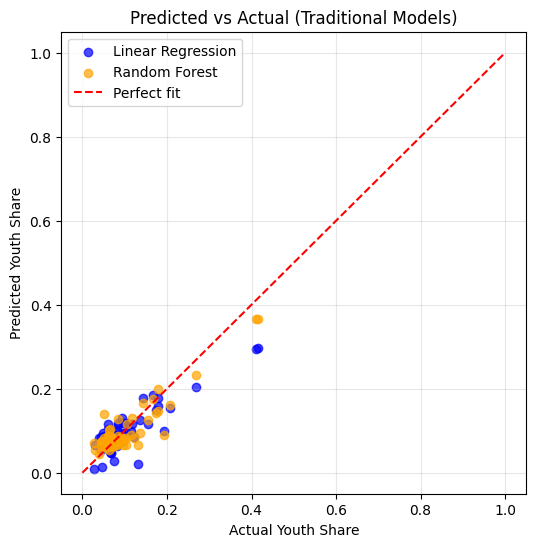

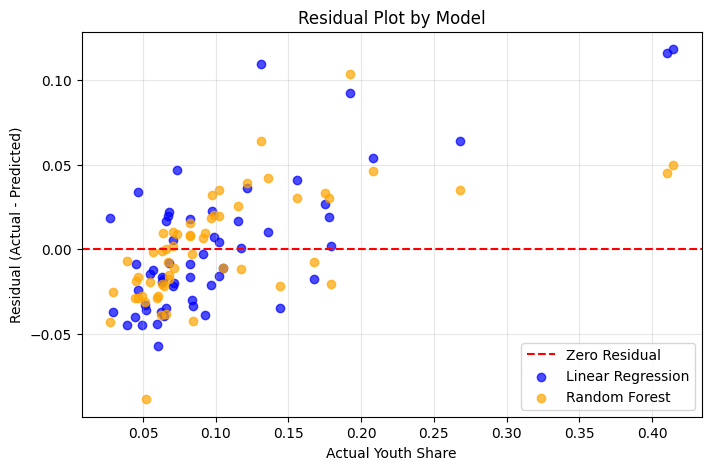

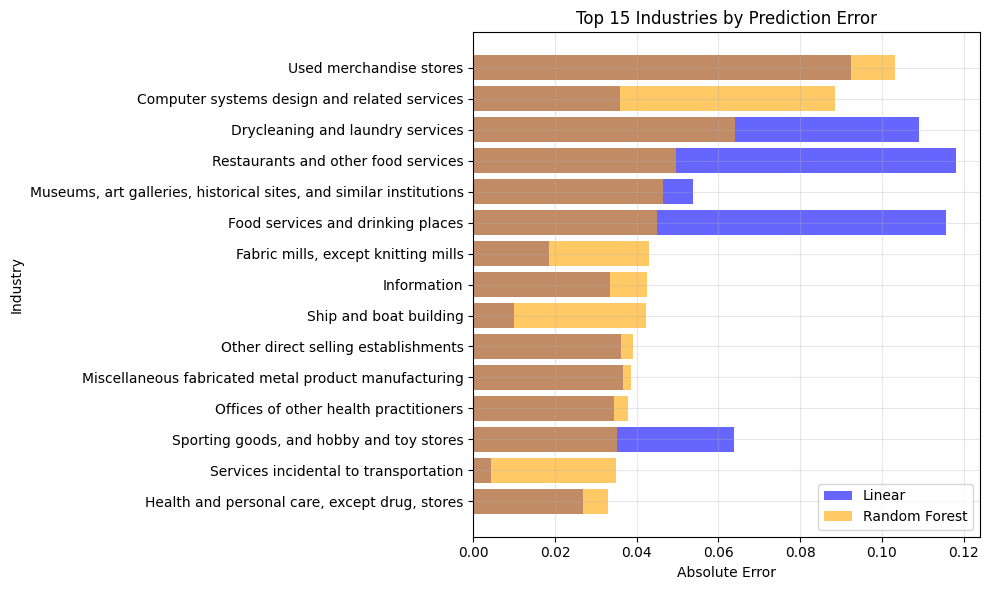

In [ ]:
# Feature importances
feat_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\n Random Forest Feature Importances:")
display(feat_importances)

# Visualization 1 — Predicted vs Actual Plot
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_lin, alpha=0.7, label='Linear Regression', color='blue')
plt.scatter(y_test, y_pred_rf, alpha=0.7, label='Random Forest', color='orange')
plt.plot([0, 1], [0, 1], 'r--', label='Perfect fit')
plt.xlabel('Actual Youth Share')
plt.ylabel('Predicted Youth Share')
plt.title('Predicted vs Actual (Traditional Models)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# 8.Visualization Residual Plot
residuals_lin = y_test - y_pred_lin
residuals_rf = y_test - y_pred_rf

plt.figure(figsize=(8, 5))
plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
plt.scatter(y_test, residuals_lin, alpha=0.7, label='Linear Regression', color='blue')
plt.scatter(y_test, residuals_rf, alpha=0.7, label='Random Forest', color='orange')
plt.xlabel('Actual Youth Share')
plt.ylabel('Residual (Actual - Predicted)')
plt.title('Residual Plot by Model')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# 9.Visualization Industry-Level Error Bars
abs_error_lin = np.abs(y_test - y_pred_lin)
abs_error_rf = np.abs(y_test - y_pred_rf)

# Build error DataFrame with industry names
errors_df = pd.DataFrame({
    'Industry': df.loc[y_test.index, 'Industry'],
    'Linear_Error': abs_error_lin,
    'RF_Error': abs_error_rf
}).sort_values(by='RF_Error', ascending=False).head(15)  # top 15 mispredicted

plt.figure(figsize=(10, 6))
plt.barh(errors_df['Industry'], errors_df['Linear_Error'], color='blue', alpha=0.6, label='Linear')
plt.barh(errors_df['Industry'], errors_df['RF_Error'], color='orange', alpha=0.6, label='Random Forest')
plt.xlabel('Absolute Error')
plt.ylabel('Industry')
plt.title('Top 15 Industries by Prediction Error')
plt.gca().invert_yaxis()
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# 2. Deep Learning Models for Youth Share Prediction
 *Using TensorFlow (Sequential + Functional API)*

 2.1. Overview & Rationale

While traditional models like Linear Regression and Random Forest provided strong baselines and valuable interpretability they operate within fixed structural assumptions. To push beyond these limits and explore whether deeper, more adaptive architectures could better capture the nuanced dynamics of youth labor concentration, I introduced two deep neural network (DNN) models.

The first is a Sequential Neural Network: a clean, feedforward architecture that learns hierarchical representations of the input features—ideal for uncovering non-linear relationships between an industry’s age structure and its reliance on young workers.

The second leverages TensorFlow’s Functional API, offering greater flexibility in model design. This approach allows for custom layer configurations, skip connections (if needed), and fine-grained control over information flow—useful not just for performance, but for future extensions.

We turn to deep learning not only because the labor market is relational shaped by non-linear interactions among age cohorts, thresholds, and sector-specific dynamics that simpler models oversimplify but also because deep neural networks offer future-proof scalability, allowing the seamless integration of richer features like wages, unionization, or geography to evolve this project into a dynamic, class-aware mapping tool over time.


In [ ]:
# 1. Import libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

2.2. Data Loading and Preprocessing

* Same preprocessed dataset as traditional models to ensure direct comparability.

* Features were standardized (using z-score normalization) to stabilize neural network training because unlike tree-based models, neural networks benefit from scaling to improve convergence and gradient flow.

* The same train-test split (80/20) and random seed were used.

This guarantees that any performance differences come from the model architecture, not data discrepancies.

In [ ]:
# Load and prepare dataset (same as traditional ML)
file_path = 'cpsaat18b.xlsx'
df = pd.read_excel(file_path, sheet_name='cpsaat18b', skiprows=5)
df.columns = [
    'Industry',
    'Total_16_plus',
    'Age_16_19',
    'Age_20_24',
    'Age_25_34',
    'Age_35_44',
    'Age_45_54',
    'Age_55_64',
    'Age_65_plus',
    'Median_Age'
]
# Drop rows with missing total and convert numeric columns
df = df.dropna(subset=['Total_16_plus'])
numeric_cols = df.columns[1:]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
df = df.dropna(subset=numeric_cols)

# Target: Youth share
df['Youth_Share'] = (df['Age_16_19'] + df['Age_20_24']) / df['Total_16_plus']

# Drop total rows
df = df[df['Industry'].notna() & (df['Industry'] != 'Total, 16 years and over')]

# Define features and target
X = df[['Age_25_34', 'Age_35_44', 'Age_45_54', 'Age_55_64', 'Age_65_plus', 'Median_Age']]
y = df['Youth_Share'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create TensorFlow datasets
batch_size = 16
train_ds = tf.data.Dataset.from_tensor_slices((X_train_scaled, y_train)).batch(batch_size).shuffle(buffer_size=128)
test_ds = tf.data.Dataset.from_tensor_slices((X_test_scaled, y_test)).batch(batch_size)

2.3. Model Architecture & Hyperparameters

To explore whether deep learning could improve upon traditional models in capturing the nuanced relationship between industry demographics and youth labor share, I implemented two neural network architectures using TensorFlow/Keras.

*a. Sequential Model*

This served as the primary deep learning baseline—a clean, feedforward network with:

* Two hidden dense layers (64 and 32 units), each using ReLU activation to introduce non-linearity while maintaining training stability.
* A dropout layer (rate = 0.3) after the first hidden layer to reduce overfitting by randomly deactivating neurons during training—a simple but effective form of regularization for small-to-moderate tabular datasets.
* A linear output layer (no activation), standard for regression tasks, ensuring predictions remain unbounded and interpretable as continuous proportions.
* The model was compiled with the Adam optimizer, which adapts learning rates per parameter and works well out-of-the-box.
* MAE and MSE were tracked as metrics to monitor both average error and sensitivity to outliers during training.

*b. Functional API Model*

Built with the same core components, this version used TensorFlow’s Functional API instead of the Sequential API. While performance was slightly lower (R² = 0.805 vs. 0.864), this architecture offers greater modularity enabling future enhancements like.
Both models were trained with:

* Batch size = 16 (a common choice for small datasets that balances gradient stability and memory efficiency),
* Up to 200 epochs,
* Early stopping on validation loss with patience = 20, halting training once performance plateaued typically around 60–80 epochs.

In [ ]:
# Sequential Model
seq_model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)  # regression output
])

seq_model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae', 'mse']
)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_seq = seq_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=200,
    callbacks=[early_stop],
    verbose=1
)

# Predictions
y_pred_seq = seq_model.predict(X_test_scaled).flatten()

# Evaluation metrics
def evaluate_model_dl(name, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f"--- {name} ---")
    print(f"R² Score: {r2:.4f}")
    print(f"MSE: {mse:.6f}")
    print(f"RMSE: {rmse:.6f}")
    print(f"MAE: {mae:.6f}")
    print("-"*40)
    return r2, mse, rmse, mae

seq_scores = evaluate_model_dl("Sequential Model", y_test, y_pred_seq)

# Functional API Model
inputs = keras.Input(shape=(X_train.shape[1],))
x = layers.Dense(64, activation='relu')(inputs)
x = layers.Dropout(0.2)(x)  # regularization
x = layers.Dense(32, activation='relu')(x)
outputs = layers.Dense(1)(x)

func_model = keras.Model(inputs=inputs, outputs=outputs)

func_model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae', 'mse']
)

history_func = func_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=200,
    callbacks=[early_stop],
    verbose=1
)

y_pred_func = func_model.predict(X_test_scaled).flatten()
func_scores = evaluate_model_dl("Functional Model", y_test, y_pred_func)

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1211 - mae: 0.2149 - mse: 0.1211 - val_loss: 0.0145 - val_mae: 0.0715 - val_mse: 0.0145
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0211 - mae: 0.0787 - mse: 0.0211 - val_loss: 0.0032 - val_mae: 0.0421 - val_mse: 0.0032
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0044 - mae: 0.0481 - mse: 0.0044 - val_loss: 0.0020 - val_mae: 0.0355 - val_mse: 0.0020
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0040 - mae: 0.0426 - mse: 0.0040 - val_loss: 0.0023 - val_mae: 0.0340 - val_mse: 0.0023
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0382 - mse: 0.0030 - val_loss: 0.0014 - val_mae: 0.0292 - val_mse: 0.0014
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0025 - mae: 0.0375 - mse: 0.0025 - val_loss: 0.0015 - val_mae: 0.0301 - val_mse: 0.0015
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0018 - mae: 0.0321 - mse: 0.0018 - val_loss:

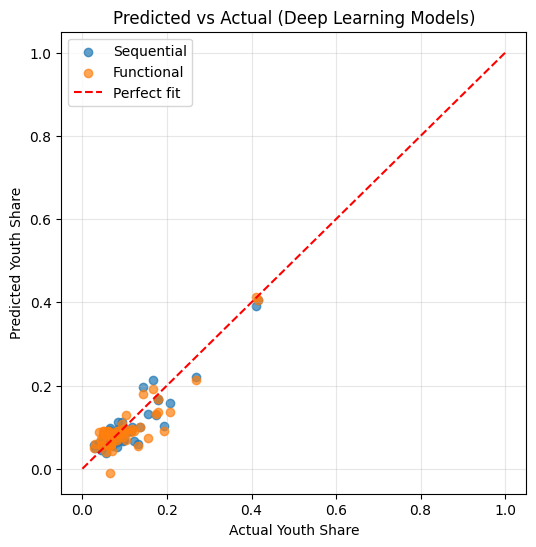

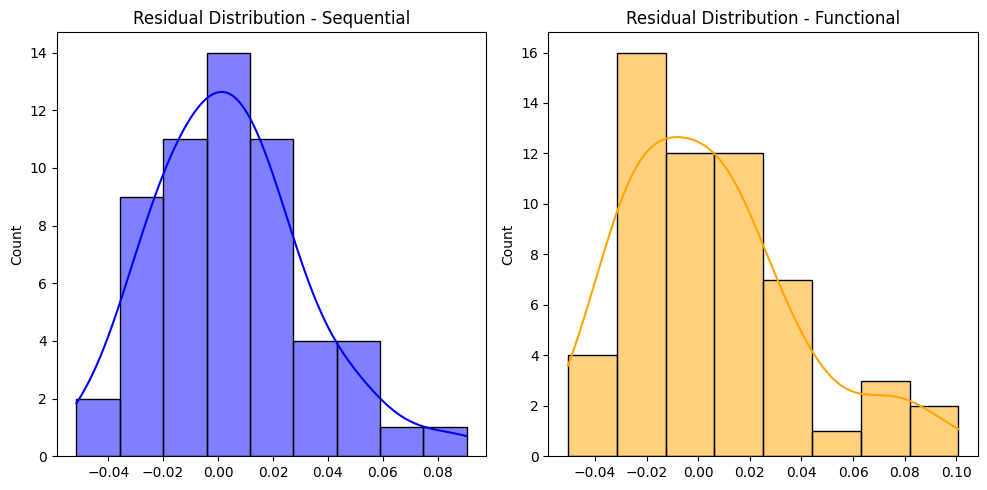

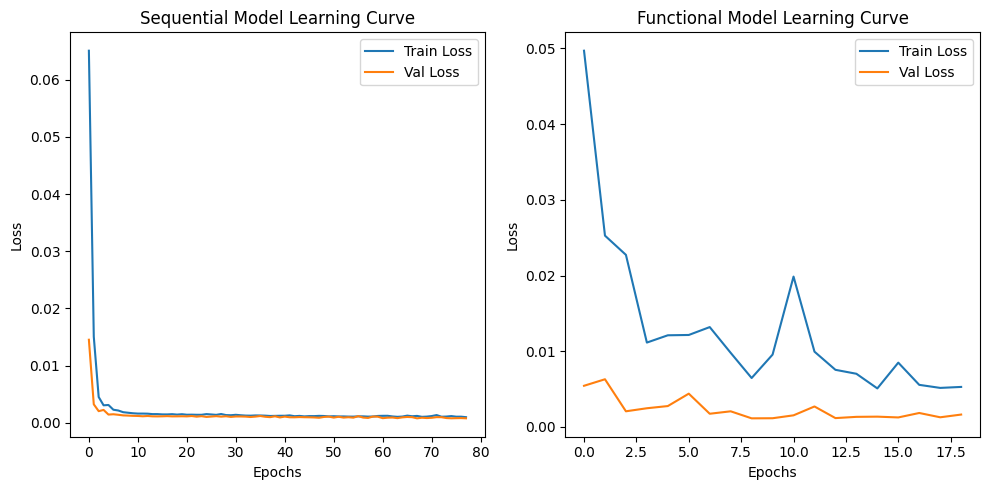

In [ ]:
# Visualization & Diagnostics

# Predicted vs Actual
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_seq, alpha=0.7, label='Sequential')
plt.scatter(y_test, y_pred_func, alpha=0.7, label='Functional')
plt.plot([0, 1], [0, 1], 'r--', label='Perfect fit')
plt.xlabel('Actual Youth Share')
plt.ylabel('Predicted Youth Share')
plt.title('Predicted vs Actual (Deep Learning Models)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Residual plots
residuals_seq = y_test - y_pred_seq
residuals_func = y_test - y_pred_func

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(residuals_seq, kde=True, color='blue')
plt.title('Residual Distribution - Sequential')

plt.subplot(1, 2, 2)
sns.histplot(residuals_func, kde=True, color='orange')
plt.title('Residual Distribution - Functional')
plt.tight_layout()
plt.show()

# Learning curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history_seq.history['loss'], label='Train Loss')
plt.plot(history_seq.history['val_loss'], label='Val Loss')
plt.title('Sequential Model Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_func.history['loss'], label='Train Loss')
plt.plot(history_func.history['val_loss'], label='Val Loss')
plt.title('Functional Model Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()